<a href="https://colab.research.google.com/github/rahulnani04/CSC-637--SentimentAnalysis-Twitter/blob/main/sentiment_analysis_with_amazon_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install numpy==1.24.4 scipy==1.13.1 pandas==2.2.2 --force-reinstall


  Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl.metadata (8.4 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached six-1.17.0-py2.py3-none-any.whl.metadata (1.7 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 92.4 MB/s eta 0:00:00
Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (38.6 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 77.4 MB/s eta 0:00:00
Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl (229 kB)
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
Using cached six-1.17.0-py2.py3-none-any.whl (11 kB)
  Attempting uninstall: pytz
    Found existing installation: pytz 2025.2
    Uninstalling pytz-2025.2:
      Successfully unin

In [1]:
import pandas as pd
import nltk
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
df = pd.read_csv('/content/corpus (2).csv', encoding='ISO-8859-1')


In [4]:
print(df.head())
print(df.columns)


                                                text        label
0   Stuning even for the non-gamer: This sound tr...  __label__2 
1   The best soundtrack ever to anything.: I'm re...  __label__2 
2   Amazing!: This soundtrack is my favorite musi...  __label__2 
3   Excellent Soundtrack: I truly like this sound...  __label__2 
4   Remember, Pull Your Jaw Off The Floor After H...  __label__2 
Index(['text', 'label'], dtype='object')


In [5]:
# Convert __label__2 → 1 and __label__1 → 0
df['label'] = df['label'].apply(lambda x: 1 if x.strip() == '__label__2' else 0)


In [8]:
import re
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')

# Use RegexpTokenizer to avoid punkt
tokenizer = RegexpTokenizer(r'\b[a-zA-Z]{2,}\b')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = str(text).lower()
    tokens = tokenizer.tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

df['cleaned'] = df['text'].apply(clean_text)



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Vectorize cleaned text
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['cleaned']).toarray()
y = df['label']

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [10]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)


LogisticRegression()

In [11]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8525
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.86      0.86      1037
           1       0.85      0.84      0.85       963

    accuracy                           0.85      2000
   macro avg       0.85      0.85      0.85      2000
weighted avg       0.85      0.85      0.85      2000



In [12]:
import gensim.downloader as api

# This will take a minute to load (~1.6GB)
w2v_model = api.load("word2vec-google-news-300")


[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [13]:
import numpy as np

def get_w2v_vector(text):
    tokens = text.split()
    vectors = [w2v_model[word] for word in tokens if word in w2v_model]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(300)

# Apply to dataset
X_w2v = df['cleaned'].apply(get_w2v_vector)
X_w2v = np.vstack(X_w2v.values)


In [14]:
# Train/test split for Word2Vec vectors
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(X_w2v, y, test_size=0.2, random_state=42)

# Train model
model_w2v = LogisticRegression(max_iter=1000)
model_w2v.fit(X_train_w2v, y_train_w2v)

# Evaluate
y_pred_w2v = model_w2v.predict(X_test_w2v)

print("Word2Vec Accuracy:", accuracy_score(y_test_w2v, y_pred_w2v))
print("Word2Vec Classification Report:\n", classification_report(y_test_w2v, y_pred_w2v))


Word2Vec Accuracy: 0.8345
Word2Vec Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.86      0.84      1037
           1       0.84      0.81      0.82       963

    accuracy                           0.83      2000
   macro avg       0.84      0.83      0.83      2000
weighted avg       0.83      0.83      0.83      2000



In [15]:
def predict_sentiment_tfidf(text):
    cleaned = clean_text(text)
    vector = vectorizer.transform([cleaned]).toarray()
    prediction = model.predict(vector)[0]
    return "Positive" if prediction == 1 else "Negative"

# Example  to predict sentiment
print(predict_sentiment_tfidf("I love this soundtrack, it's amazing!"))


Positive


In [16]:
def predict_sentiment_w2v(text):
    cleaned = clean_text(text)
    vector = get_w2v_vector(cleaned).reshape(1, -1)
    prediction = model_w2v.predict(vector)[0]
    return "Positive" if prediction == 1 else "Negative"

# Example to predict sentiment
print(predict_sentiment_w2v("This movie was a disaster and I hated it."))



Negative


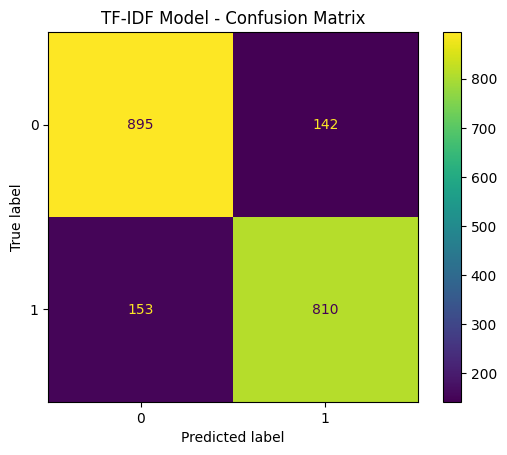

TF-IDF Model F1 Score: 0.8459530026109661


In [20]:
from sklearn.metrics import ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt

# Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("TF-IDF Model - Confusion Matrix")
plt.show()

# F1 Score
print("TF-IDF Model F1 Score:", f1_score(y_test, y_pred))


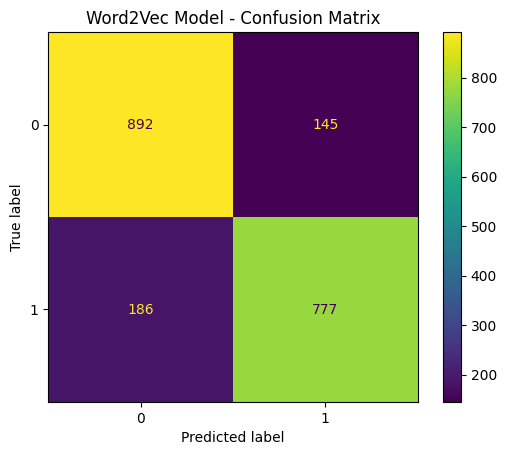

Word2Vec Model F1 Score: 0.8244031830238727


In [21]:
ConfusionMatrixDisplay.from_predictions(y_test_w2v, y_pred_w2v)
plt.title("Word2Vec Model - Confusion Matrix")
plt.show()

print("Word2Vec Model F1 Score:", f1_score(y_test_w2v, y_pred_w2v))


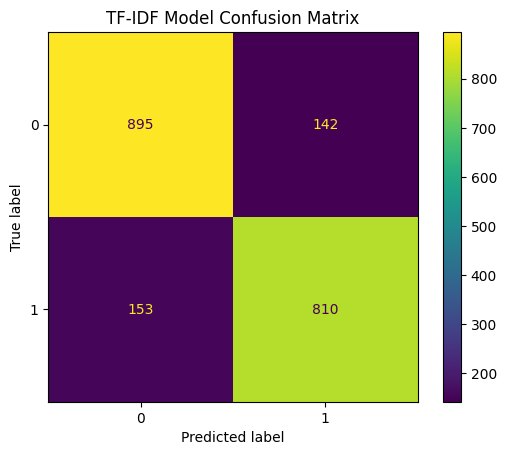

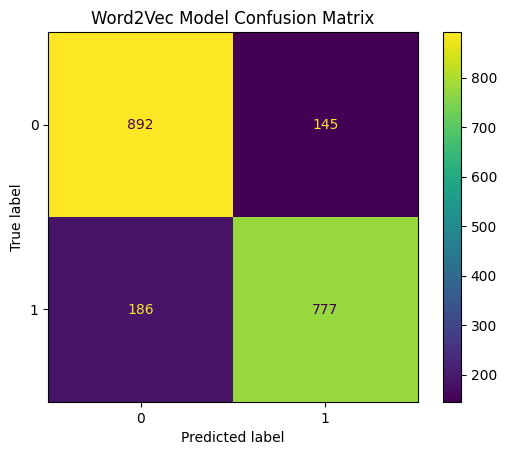

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("TF-IDF Model Confusion Matrix")
plt.show()

ConfusionMatrixDisplay.from_predictions(y_test_w2v, y_pred_w2v)
plt.title("Word2Vec Model Confusion Matrix")
plt.show()



In [19]:
# --- Function to clean user input ---
def clean_text_input(text):
    tokens = tokenizer.tokenize(text.lower())
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

# --- TF-IDF Based Sentiment Prediction ---
def predict_sentiment_tfidf(text):
    cleaned = clean_text_input(text)
    vector = vectorizer.transform([cleaned]).toarray()
    prediction = model.predict(vector)[0]
    return "Positive" if prediction == 1 else "Negative"

# --- Word2Vec Based Sentiment Prediction ---
def predict_sentiment_w2v(text):
    cleaned = clean_text_input(text)
    vector = get_w2v_vector(cleaned).reshape(1, -1)
    prediction = model_w2v.predict(vector)[0]
    return "Positive" if prediction == 1 else "Negative"

# --- custom  Input from user ---
user_input = input("Enter a review or sentence: ")

print("\n Prediction Results:")
print("TF-IDF Model:", predict_sentiment_tfidf(user_input))
print("Word2Vec Model:", predict_sentiment_w2v(user_input))


Enter a review or sentence:  I really loved this movie, it was fantastic!

 Prediction Results:
TF-IDF Model: Positive
Word2Vec Model: Positive


In [22]:
import joblib

# Save TF-IDF model and vectorizer
joblib.dump(model, 'tfidf_model.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

# Save Word2Vec-based model
joblib.dump(model_w2v, 'w2v_model.pkl')

print("  Models saved successfully.")


  Models saved successfully.


In [23]:
model = joblib.load('tfidf_model.pkl')
vectorizer = joblib.load('tfidf_vectorizer.pkl')
model_w2v = joblib.load('w2v_model.pkl')
